### 一、什么是Graph Embedding，都有哪些算法模型

   在介绍Graph Embedding之前，我们先回顾什么是Embedding？Embedding在数学上是一个函数，将一个空间的点映射到另一个空间，通常是从高维抽象的空间映射到低维的具象空间。Embeding的意义将高维数据转换到低维利于算法的处理；同时解决one-hot向量长度随样本的变化而变化，以及无法表示两个实体之间的相关性这一问题。  
Graph Embedding 的中心思想就是找到一种映射函数，该函数将网络中的每个节点转换为低维度的潜在表示。  
graph embeding的几种常见分类：DeepWalk,node2vec,GCN,ANE，LINE等


### 二、 如何使用Graph Embedding在推荐系统，比如NetFlix 电影推荐，请说明简要的思路

+ 1、建模  
  将所有user在一段时间内的消费历史构建为一个图。
+ 2、提取特征  
  通过RandomWalk生成模型训练需要的训练数据。
+ 3、模型训练  
  通过Word2Vec模型来构建每个节点(item)的Embedding向量  
+ 针对NetFlix 电影推荐，简要思路：  
1、将所有user在一段时间内的观看电影历史构建为一个图  
2、通过RandomWalk生成模型训练需要的训练数据  
3、通过Word2Vec模型来构建每个节点(movie)的Embedding向量

### 三、数据探索EDA都有哪些常用的方法和工具

 EDA是指，在尽量少的先验假定下，进行探索通过作图、制表、方程拟合、计算特征量等手段探索数据的结构和规律  
+ 常用的方法有：  
  数据质量（是否有缺失值，异常值）、数据集中各变量之间的相关性、单一变量及多变量与于目标值的关系等  
+ 工具有：  
  箱线图、qq图、热力图、散点图、直方图、柱形图等

## Action1 
  Wikipidea页面的语义分析

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import random
from tqdm import tqdm # 导入进入条包
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
## 数据加载
data=pd.read_csv('./seealsology-data.tsv', sep='\t')

In [7]:
data

,source,target,depth
0,life insurance,corporate-owned life insurance,1
1,life insurance,critical illness insurance,1
2,life insurance,economic capital,1
3,life insurance,estate planning,1
4,life insurance,false insurance claims,1
...,...,...,...
3739,health system,two-tier health care,4
3740,health system,universal health care,4
3741,health administration,master of health administration,4
3742,health administration,nosokinetics,4


In [6]:
G=nx.from_pandas_edgelist(data,'source','target',\
                          edge_attr=True,create_using=nx.Graph())

In [11]:
# 随机游走
def get_randomwalk(node,path_length):
    random_walk=[node]
    for i in range(path_length-1):
        temp=list(G.neighbors(node))
        temp=list(set(temp)-set(random_walk))
        if len(temp)==0:
            break
        random_node=random.choice(temp)
        random_walk.append(random_node)
        node=random_node
    return random_walk

In [12]:
print(get_randomwalk('life insurance',10))

['life insurance', 'tontine', 'permanent life insurance', 'retirement plan', 'ham and eggs movement', 'pension', 'elderly care', 'transgenerational design', 'slow aging', 'ageing movement control']


In [14]:
# 从图中获取所有节点的列表
all_nodes=list(G.nodes())
all_nodes

['life insurance',
 'corporate-owned life insurance',
 'critical illness insurance',
 'economic capital',
 'estate planning',
 'false insurance claims',
 'general insurance',
 'internal revenue code section 79',
 'life expectancy',
 'pet insurance',
 'retirement plan',
 'return of premium life insurance',
 'segregated fund',
 "servicemembers' group life insurance",
 'term life insurance',
 'tontine',
 'universal life insurance',
 'variable universal life insurance',
 'unitised insurance fund',
 'family income benefit insurance',
 'permanent life insurance',
 'theory of decreasing responsibility',
 'whole life insurance',
 'elderly care',
 'financial advisor',
 'fee-only financial advisor',
 'generational accounting',
 'pension led funding',
 'pension model',
 'pensions crisis',
 'public debt',
 'retirement',
 'retirement age',
 'retirement planning',
 'social pension',
 'ham and eggs movement',
 'individual pension plan',
 'pension rights center',
 'roth 401(k)',
 'universities superan

In [16]:
# 捕获数据集中所有节点的随机游走序列
random_walks=[]
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|███████████████████████████████████████████████████████████████████████████| 2399/2399 [00:00<00:00, 13072.68it/s]


In [18]:
# 输出随机游走序列，及序列个数
print(random_walks)
print(len(random_walks))

[['life insurance', "servicemembers' group life insurance", 'permanent life insurance', 'life expectancy', 'calorie restriction', 'intermittent fasting', '2010s in food'], ['life insurance', 'whole life insurance', 'family income benefit insurance', 'theory of decreasing responsibility', 'term life insurance', 'permanent life insurance', 'critical illness insurance', 'total permanent disability insurance'], ['life insurance', 'critical illness insurance', 'total permanent disability insurance'], ['life insurance', 'tontine', 'permanent life insurance', 'economic capital', 'health insurance', 'social security', 'health care system'], ['life insurance', 'corporate-owned life insurance', 'permanent life insurance', 'return of premium life insurance'], ['corporate-owned life insurance', 'h. h. holmes', 'insurable interest', 'life insurance', 'critical illness insurance', 'health insurance', 'economic capital', 'basel ii', 'own risk and solvency assessment (orsa)', 'solvency ii'], ['corpora

In [20]:
# 使用skip-gram,提取模型学习到的权重
from gensim.models import Word2Vec
import warnings 
warnings.filterwarnings('ignore')

#### Word2Vec主要参数
+ window ：为训练的窗口大小，8表示每个词考虑前8个词与后8个词，默认值为5
+ sg : 用于设置训练算法，默认为0，对于CBOW算法，sg=1则采用skip-gram算法
+ seed: 用于随机数发生器。与初始化词向量有关
+ min_count: 可以用于对字典做截断，词频少于min_count次数的单词会被丢弃掉，默认值为5
+ min_alpha：学习率的最小值
+ iter： 迭代次数，默认为5
+ sorted_vocab： 如果为1（默认），则在分配word index 的时候会先对单词基于频率降序排序。

### 利用gensim.models.Word2Vec(sentences)建立词向量模型  
该构造函数执行了三个步骤：建立一个空的模型对象，遍历一次语料库建立词典，第二次遍历语料库建立神经网络模型可以通过分别执行model=gensim.models.Word2Vec()，model.build_vocab(sentences)，model.train(sentences)来实现


In [21]:
# 训练skip-gram(word2vec)模型
model=Word2Vec(window=4,sg=1,hs=0,negative=10,alpha=0.03,min_alpha=0.0007,seed=14)

In [22]:
# 从random_walks 中创建词汇表
model.build_vocab(random_walks,progress_per=2)
model.train(random_walks,total_examples=model.corpus_count,epochs=20,report_delay=1)
print(model)

Word2Vec(vocab=2399, size=100, alpha=0.03)


In [23]:
#输出和life insurance，相似
print(model.similar_by_word('life insurance'))

[('return of premium life insurance', 0.8375460505485535), ('permanent life insurance', 0.8165857791900635), ('anicom', 0.8161805868148804), ('tontine', 0.8150714635848999), ('term life insurance', 0.8067207336425781), ('whole life insurance', 0.803980827331543), ('internal revenue code section 79', 0.8000198602676392), ('pet insurance', 0.7983075380325317), ('corporate-owned life insurance', 0.7947520613670349), ('family income benefit insurance', 0.7858859300613403)]


In [26]:
# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
    #每个节点的embeding为100维
    X=model[word_list]
    #将100维向量减少到2维
    pca=PCA(n_components=2)
    result=pca.fit_transform(X)
    #绘制节点向量
    plt.figure(figsize=(12,9))
    #创建一个散点图的投影
    plt.scatter(result[:,0],result[:,1])
    for i,word in enumerate(word_list):
        plt.annotate(word,xy=(result[i,0],result[i,1]))
    plt.show()

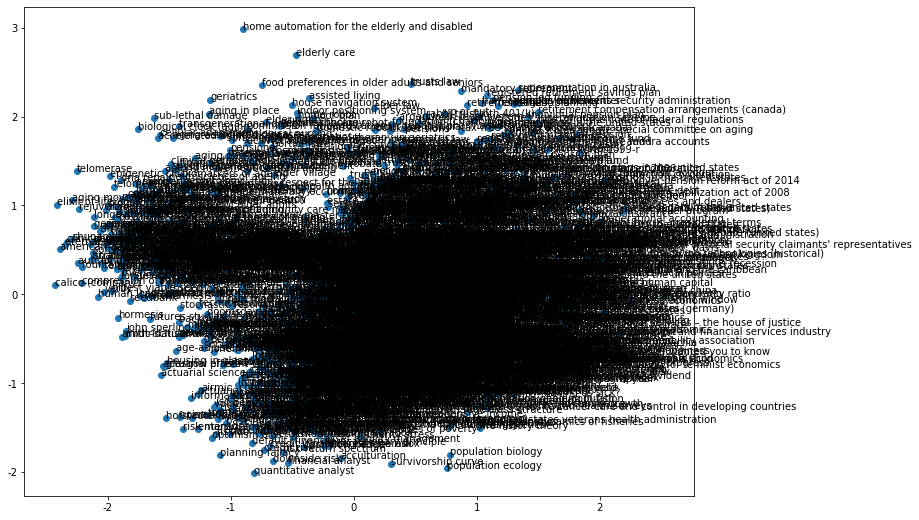

In [27]:
plot_nodes(model.wv.vocab)